In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

In [174]:
sns.set(style="dark")

In [175]:
df1 = pd.read_csv('./dataset//Dataset_FireWatch_Brazil_Q1_2024.csv')
df2 = pd.read_csv('./dataset//Dataset_FireWatch_Brazil_Q2_2024.csv')
df3 = pd.read_csv('./dataset//Dataset_FireWatch_Brazil_Q3_2024.csv')

In [176]:
df_completo = pd.concat([df1, df2, df3], ignore_index=True)

In [177]:
# Criar uma cópia do DataFrame original e preencher valores nulos
df = df_completo.copy()

# Preenchendo os valores nulos nas colunas numéricas com a mediana
df['avg_frp'] = df['avg_frp'].fillna(df['avg_frp'].median())

# Para colunas categóricas, use a moda
df['bioma'] = df['bioma'].fillna(df['bioma'].mode()[0])


In [178]:
df['data'] = pd.to_datetime(df['data'])

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162093 entries, 0 to 162092
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   data                       162093 non-null  datetime64[ns]
 1   municipio                  162093 non-null  object        
 2   estado                     162093 non-null  object        
 3   bioma                      162093 non-null  object        
 4   avg_numero_dias_sem_chuva  162093 non-null  float64       
 5   avg_precipitacao           162093 non-null  float64       
 6   avg_risco_fogo             162093 non-null  float64       
 7   avg_frp                    162093 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 9.9+ MB


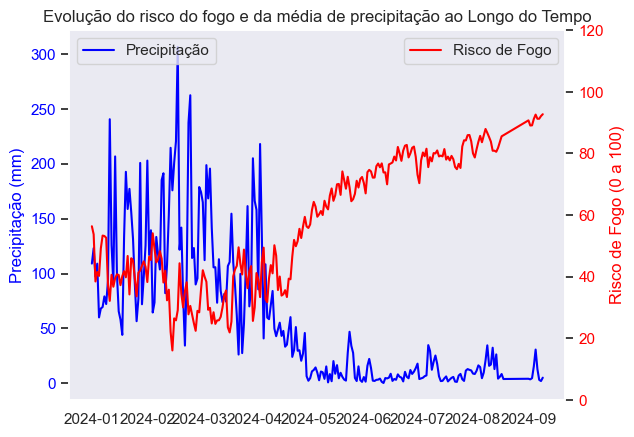

In [180]:
# Grafico de comparação entre a precipitação e o risco de fogo
# Filtrar o DataFrame para remover valores de risco de fogo igual a 0
df_filtered = df[df['avg_risco_fogo'] != 0]

# Configuração do gráfico
fig, ax1 = plt.subplots()

# Plotando a primeira linha (precipitação)
sns.lineplot(x='data', y='avg_precipitacao', data=df_filtered, ax=ax1, label='Precipitação', color='blue', errorbar=None)
ax1.set_ylabel('Precipitação (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Criando um segundo eixo Y para o risco de fogo
ax2 = ax1.twinx()
sns.lineplot(x='data', y='avg_risco_fogo', data=df_filtered, ax=ax2, label='Risco de Fogo', color='red', errorbar=None)
ax2.set_ylabel('Risco de Fogo (0 a 100)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Removendo o rótulo do eixo X
ax1.set_xlabel('')

# Mover a legenda para o canto inferior direito
ax1.legend(loc='upper left')  # Legenda da primeira linha (precipitação)
ax2.legend(loc='upper right')  # Legenda da segunda linha (risco de fogo)

# Ajustes do gráfico
plt.title("Evolução do risco do fogo e da média de precipitação ao Longo do Tempo")
ax2.set_ylim(0, 120)  # Aumentando a escala do eixo Y do risco de fogo

# Exibindo o gráfico
plt.show()


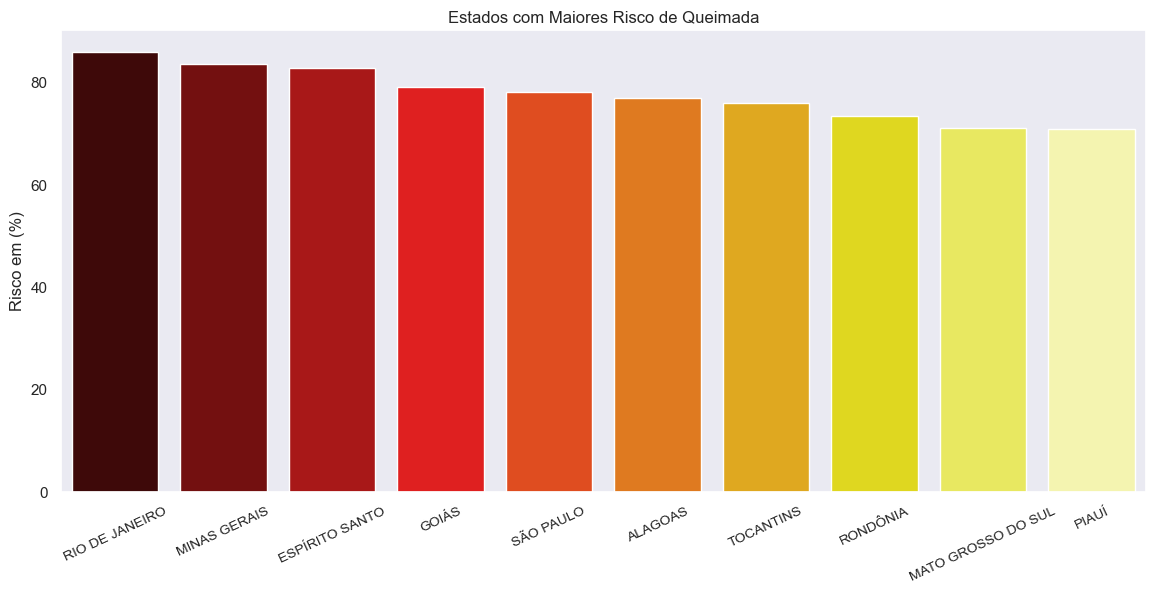

In [181]:
# Top 10 estados com maior risco de fogo
top_estados_risco = df_filtered.groupby('estado')['avg_risco_fogo'].mean().nlargest(10).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='estado', y='avg_risco_fogo', data=top_estados_risco, palette='hot', hue='estado', legend=False)
plt.title('Estados com Maiores Risco de Queimada')
plt.xlabel('')
plt.xticks(rotation=25, fontsize=10)
plt.ylabel('Risco em (%)')
plt.show()

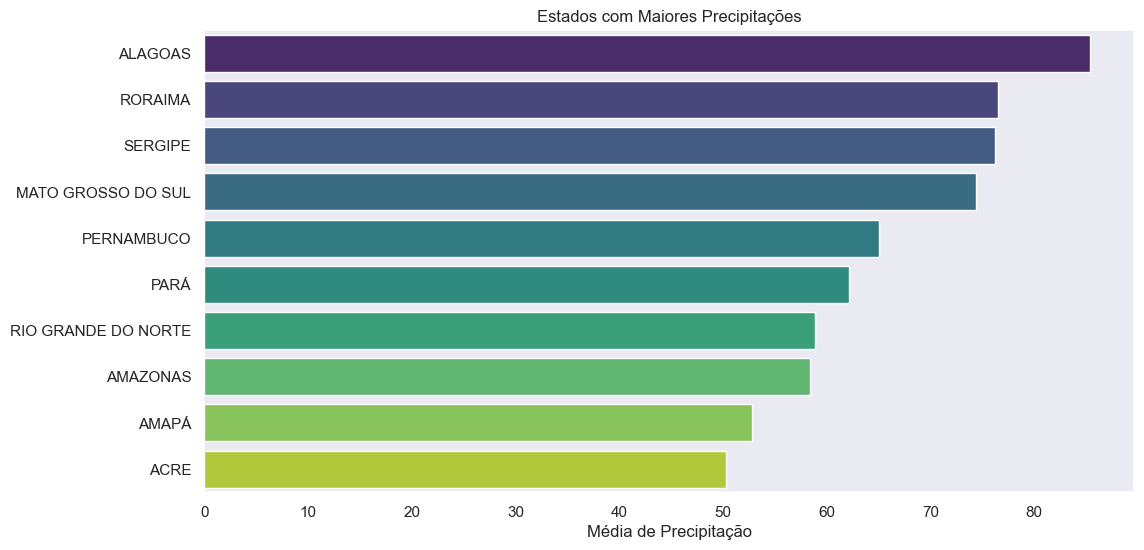

In [182]:
# Top 10 estados com maior precipitação
top_estados_precip = df_filtered.groupby('estado')['avg_precipitacao'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_precipitacao', y='estado', data=top_estados_precip, palette='viridis', hue='estado', legend=False)
plt.title('Estados com Maiores Precipitações')
plt.xlabel('Média de Precipitação')
plt.ylabel('')
plt.show()

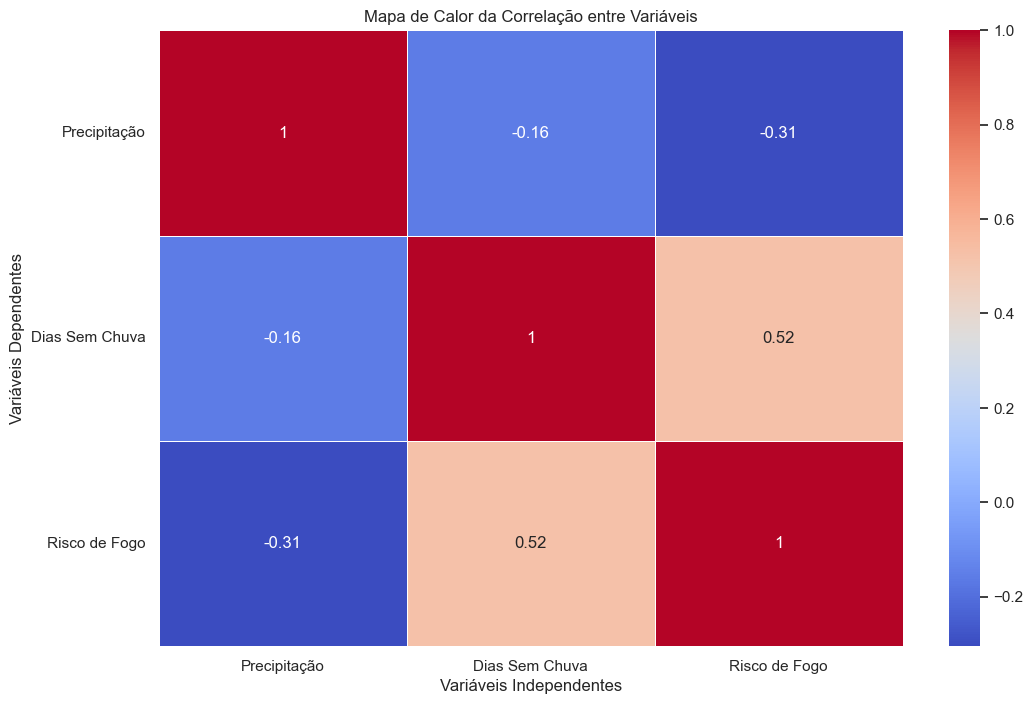

In [183]:
# Heatmap de Correlação das Variáveis
plt.figure(figsize=(12, 8))
corr_matrix = df_filtered[['avg_precipitacao', 'avg_numero_dias_sem_chuva', 'avg_risco_fogo']].corr()
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor da Correlação entre Variáveis')


heatmap.set_xlabel('Variáveis Independentes', fontsize=12)
heatmap.set_ylabel('Variáveis Dependentes', fontsize=12)

heatmap.set_xticklabels(['Precipitação', 'Dias Sem Chuva', 'Risco de Fogo'], rotation=0)
heatmap.set_yticklabels(['Precipitação', 'Dias Sem Chuva', 'Risco de Fogo'], rotation=0)

plt.show()

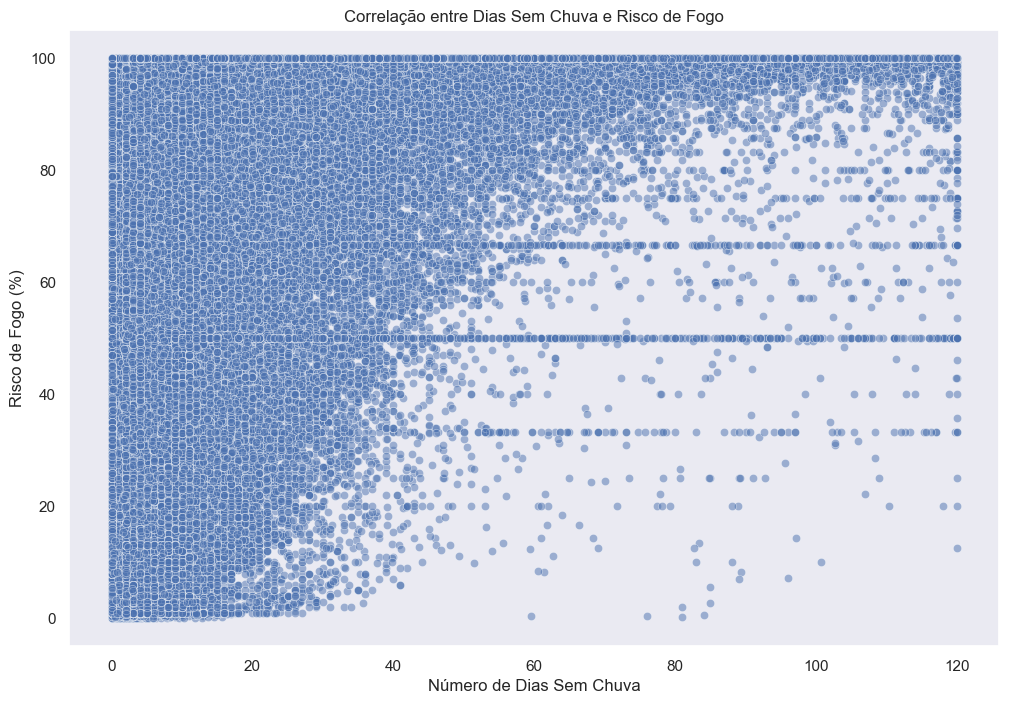

Coeficiente de correlação entre Dias Sem Chuva e Risco de Fogo: 0.524


In [184]:
plt.figure(figsize=(12, 8))

# Remover valores vazios (NaN)
df_clean = df_filtered.dropna(subset=['avg_numero_dias_sem_chuva', 'avg_risco_fogo'])

# Gráfico de dispersão
sns.scatterplot(x='avg_numero_dias_sem_chuva', y='avg_risco_fogo', data=df_clean, alpha=0.5)
plt.title('Correlação entre Dias Sem Chuva e Risco de Fogo')
plt.xlabel('Número de Dias Sem Chuva')
plt.ylabel('Risco de Fogo (%)')

# Cálculo da correlação de Pearson
correlacao_dias_sem_chuva = pearsonr(df_clean['avg_numero_dias_sem_chuva'], df_clean['avg_risco_fogo'])
plt.show()

print(f"Coeficiente de correlação entre Dias Sem Chuva e Risco de Fogo: {correlacao_dias_sem_chuva[0]:.3f}")

In [185]:
# Definindo as variáveis independentes (dias sem chuva, precipitação, FRP)
X = df_filtered[['avg_numero_dias_sem_chuva', 'avg_precipitacao', 'avg_frp']]

# Variável dependente (risco de fogo)
y = df_filtered['avg_risco_fogo']

# Adicionando uma constante para o modelo 
X = sm.add_constant(X)

# Ajustando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Resumo dos resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         avg_risco_fogo   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                 2.248e+04
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:48:59   Log-Likelihood:            -6.7103e+05
No. Observations:              138761   AIC:                         1.342e+06
Df Residuals:                  138757   BIC:                         1.342e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [186]:
# Fazendo as previsões com base no modelo ajustado
y_pred = modelo.predict(X)

# Calculando o MAE
mae = mean_absolute_error(y, y_pred)

# Exibindo o resultado
print(f"Erro Absoluto Médio (MAE): {mae}")

Erro Absoluto Médio (MAE): 26.143639847039875
